In [1]:
import numpy as np
import pandas as pd
import configparser
import os  # Import os library for path operations

# Read configuration from config.ini
config = configparser.ConfigParser()
config.read('config.ini')

import scipy.stats as stats


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

# plt.style.use('fivethirtyeight')
# plt.rcParams['lines.linewidth'] = 1.5
# dark_style = {
#     'figure.facecolor': '#212946',
#     'axes.facecolor': '#212946',
#     'savefig.facecolor':'#212946',
#     'axes.grid': True,
#     'axes.grid.which': 'both',
#     'axes.spines.left': False,
#     'axes.spines.right': False,
#     'axes.spines.top': False,
#     'axes.spines.bottom': False,
#     'grid.color': '#2A3459',
#     'grid.linewidth': '1',
#     'text.color': '0.9',
#     'axes.labelcolor': '0.9',
#     'xtick.color': '0.9',
#     'ytick.color': '0.9',
#     'font.size': 12 }
# plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


In [3]:

def prepare_data(file_path):
    """
    Read CSV file and perform necessary preprocessing.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame.
    """

    # Ensure the file path exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Define data types and index column
    data_types = {
        'ds': 'str',
        'unique_id': 'category',
        'y': np.int64
    }
    index_col = 'ds'

    # Read CSV with specified data types and index
    df = pd.read_csv(file_path, dtype=data_types, parse_dates=[index_col])

    # Check if 'ds' is present in the columns
    if 'ds' not in df.columns:
        raise KeyError("The 'ds' column is not present in the DataFrame.")

    # Convert 'ds' column to datetime after reading
    df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m')  # Adjust the format based on your actual data
    
    df = df[['unique_id', 'ds', 'y']]
    
    return df

In [4]:
# Example usage:
df_path = config['Paths']['dataset_data']
df = prepare_data(df_path)


In [5]:
df.head(), df.shape

(  unique_id         ds   y
 0      0101 2018-01-01   0
 1      0101 2018-02-01  20
 2      0101 2018-03-01   1
 3      0101 2018-04-01  40
 4      0101 2018-05-01   6,
 (2829, 3))

## Forecasting with AutoARIMA and AutoETS

### Start the models

In [6]:
from statsforecast.models import (
    AutoARIMA,
    AutoETS
)
from statsforecast import StatsForecast

c:\Users\brvn\AppData\Local\anaconda3\envs\meutcc\Lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
models= [
    AutoARIMA(season_length=12),
    AutoETS(season_length=12)
]

In [34]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=df, 
    models=models,
    freq='MS', 
    n_jobs=-1
)

In [35]:
forecast_df = sf.forecast(h=12, level=[80])
forecast_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90
unique_id,,,,,,,
0101,2023-10-01,281.481812,206.822495,356.141144,407.739807,336.590576,478.889038
0101,2023-11-01,281.481812,196.323959,366.639679,426.429779,354.494141,498.365417
0101,2023-12-01,281.481812,186.984695,375.978943,445.119781,370.123749,520.115784
0101,2024-01-01,281.481812,178.488846,384.474792,463.809753,382.349060,545.270447
0101,2024-02-01,281.481812,170.642303,392.321350,482.499725,390.664673,574.334778


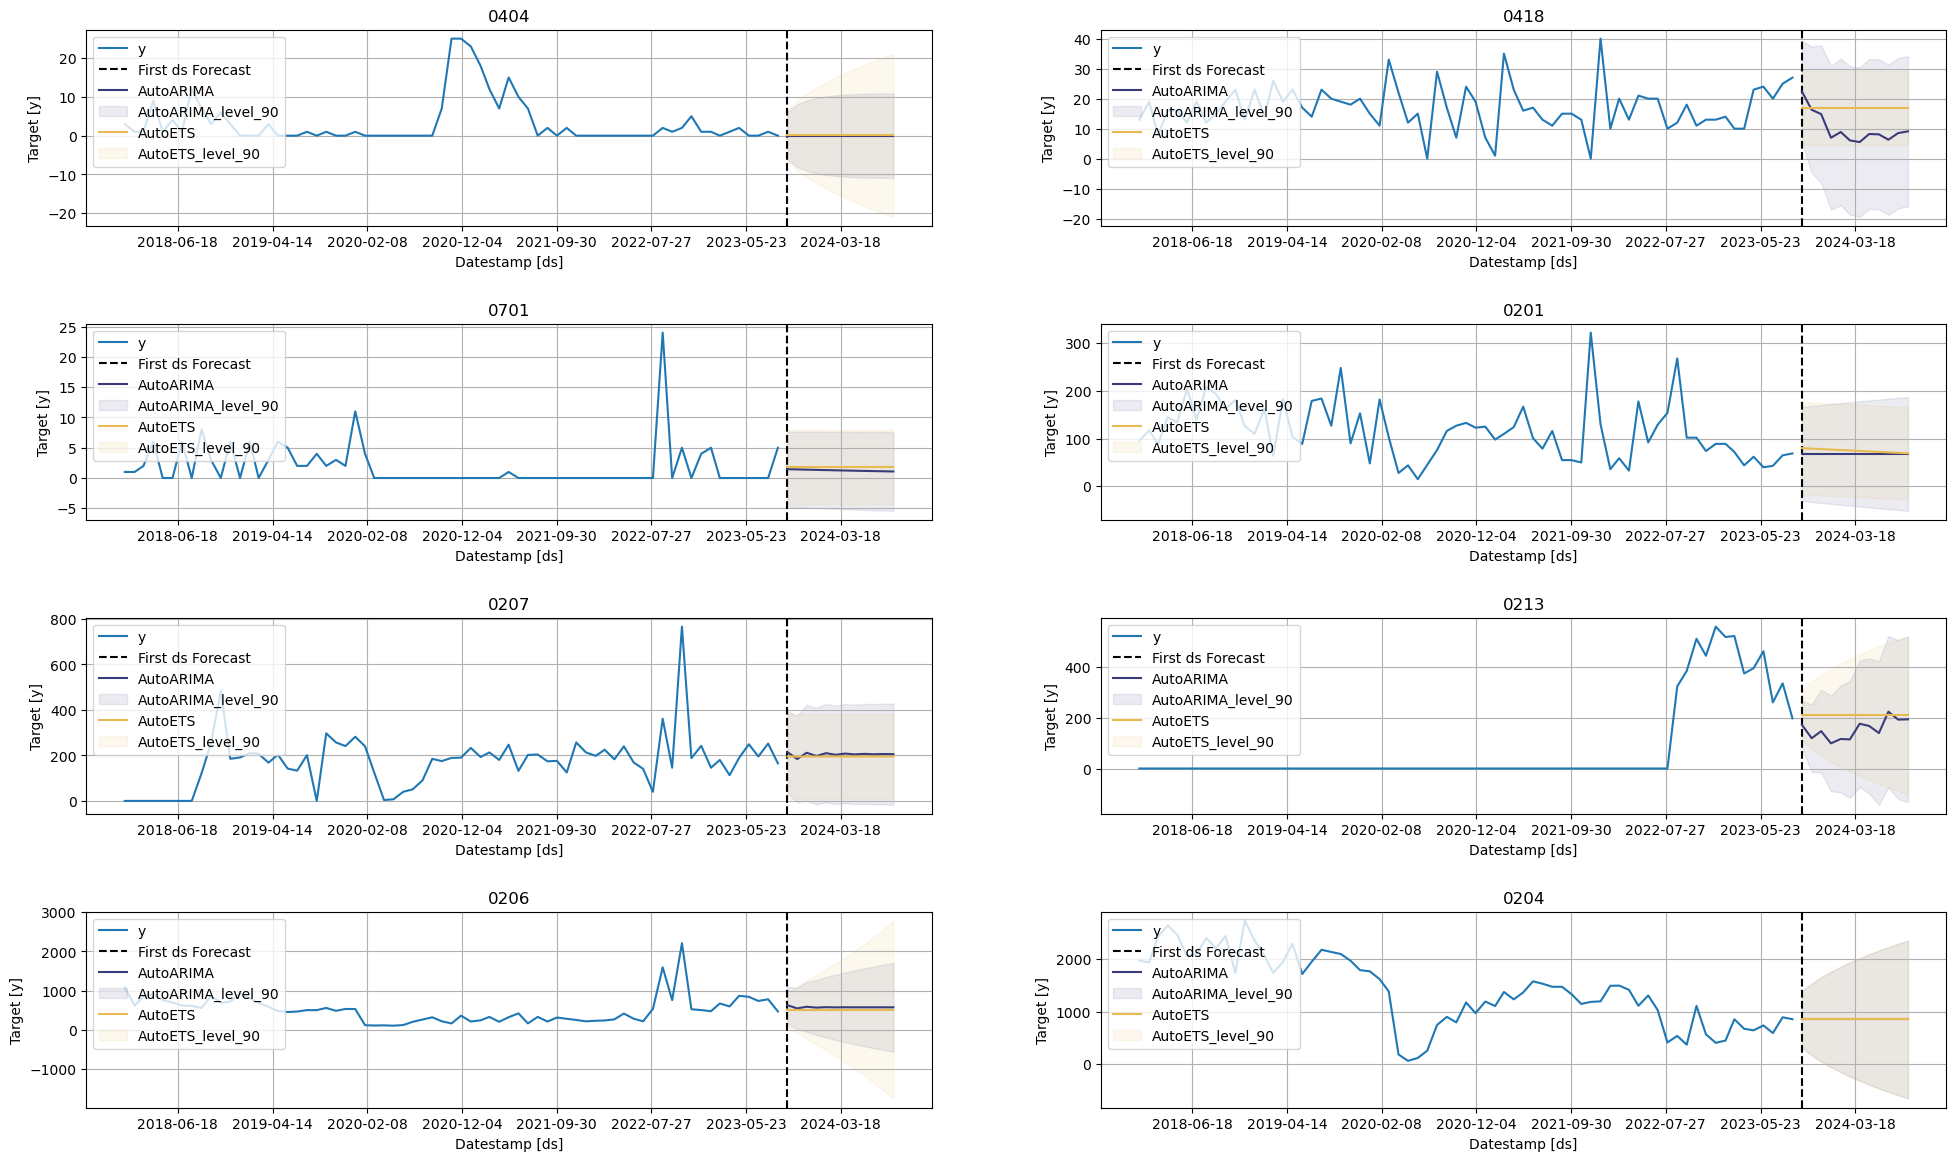

In [36]:
sf.plot(df, forecast_df, engine='matplotlib')

In [37]:
forecast_df.to_csv(r"C:\Users\brvn\Documents\github\projects\HC\tcc_brvn\data\interim\forecasts_df.csv", float_format="%d")

In [38]:
crossvaldation_df = sf.cross_validation(
    df=df,
    h=12,
    step_size=24,
    n_windows=2
  )

In [39]:
crossvaldation_df.head()
crossvaldation_df.to_csv(r"C:\Users\brvn\Documents\github\projects\HC\tcc_brvn\data\processed\cross-validation-df.csv")


In [41]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id', observed=False).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [42]:
evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(), mse)

evaluation_df.head()

,AutoARIMA,AutoETS,best_model
unique_id,,,
0101,2.249714e+04,2.339212e+04,AutoARIMA
0102,4.166667e-02,1.555650e-04,AutoETS
0201,7.253575e+03,2.534818e+03,AutoETS
0202,3.595685e+08,1.039829e+08,AutoETS
0203,5.476391e+05,2.415817e+05,AutoETS


In [43]:
# Salvar o dataframe com o melhor modelo
evaluation_df.to_csv(r"C:\Users\brvn\Documents\github\projects\HC\tcc_brvn\data\processed\best-models-df.csv")

In [44]:
#Criando um sumário dos melhores modelos
summary_df = evaluation_df.groupby('best_model').size().sort_values().to_frame()

summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]

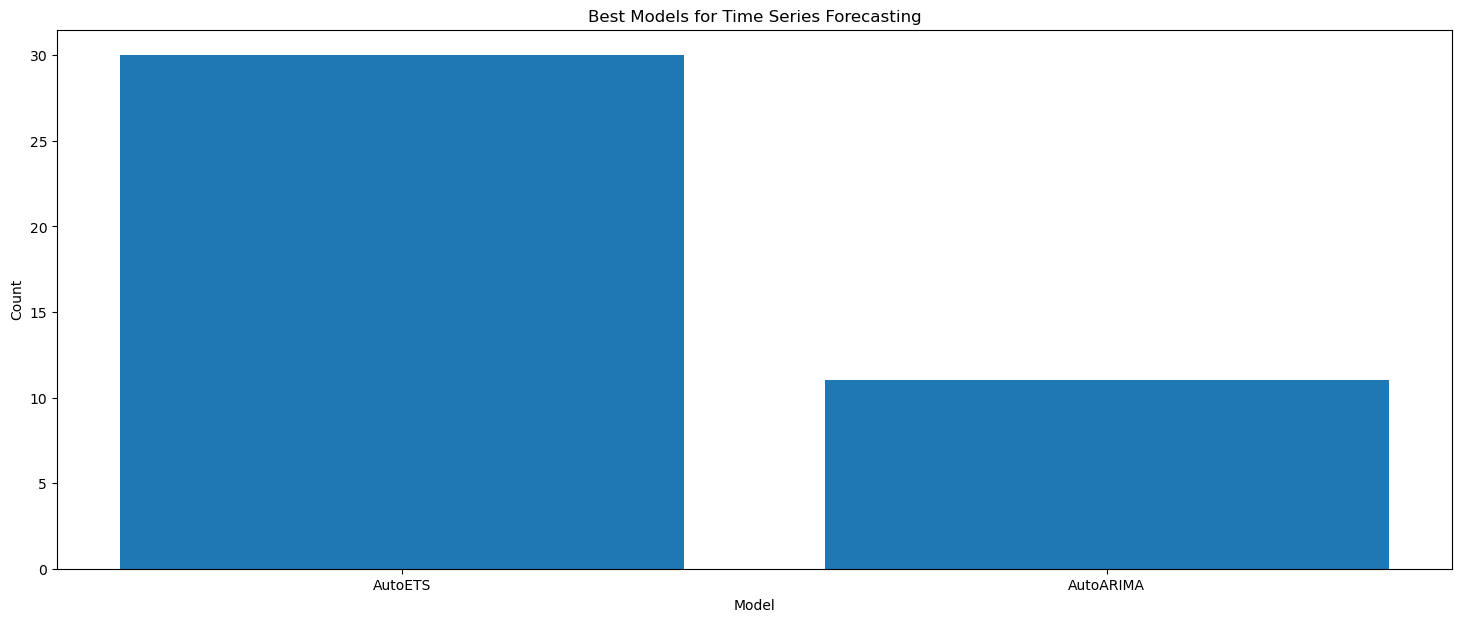

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming summary_df is the DataFrame
model_counts = evaluation_df['best_model'].value_counts()
model_counts.plot(kind='bar')

# Customize the plot
plt.title('Best Models for Time Series Forecasting')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability

plt.show()


In [54]:
autoets_ids = evaluation_df.query('best_model == "AutoETS"').index
autoarima_ids = evaluation_df.query('best_model == "AutoARIMA"').index


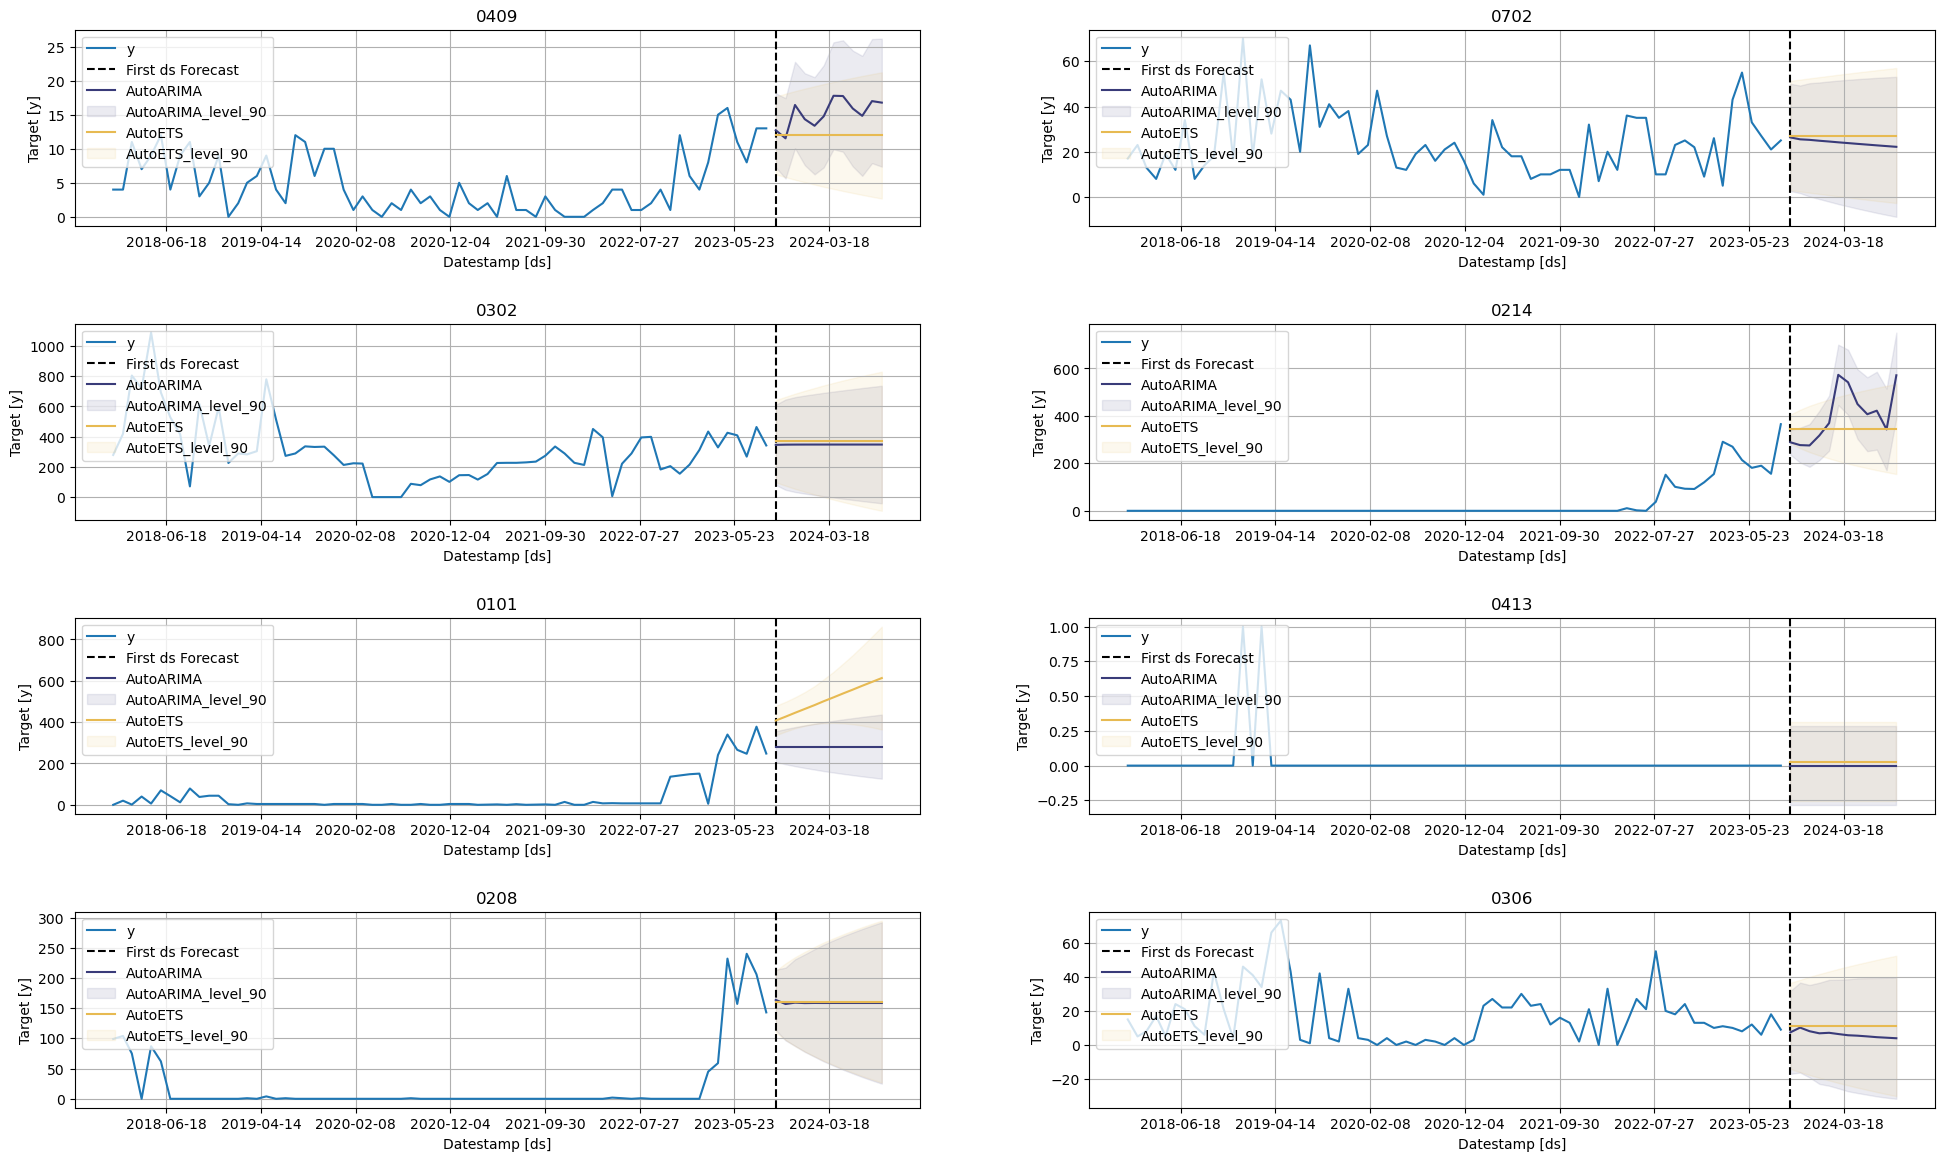

In [55]:
sf.plot(df=df,forecasts_df=forecast_df, unique_ids=autoarima_ids, engine='matplotlib')

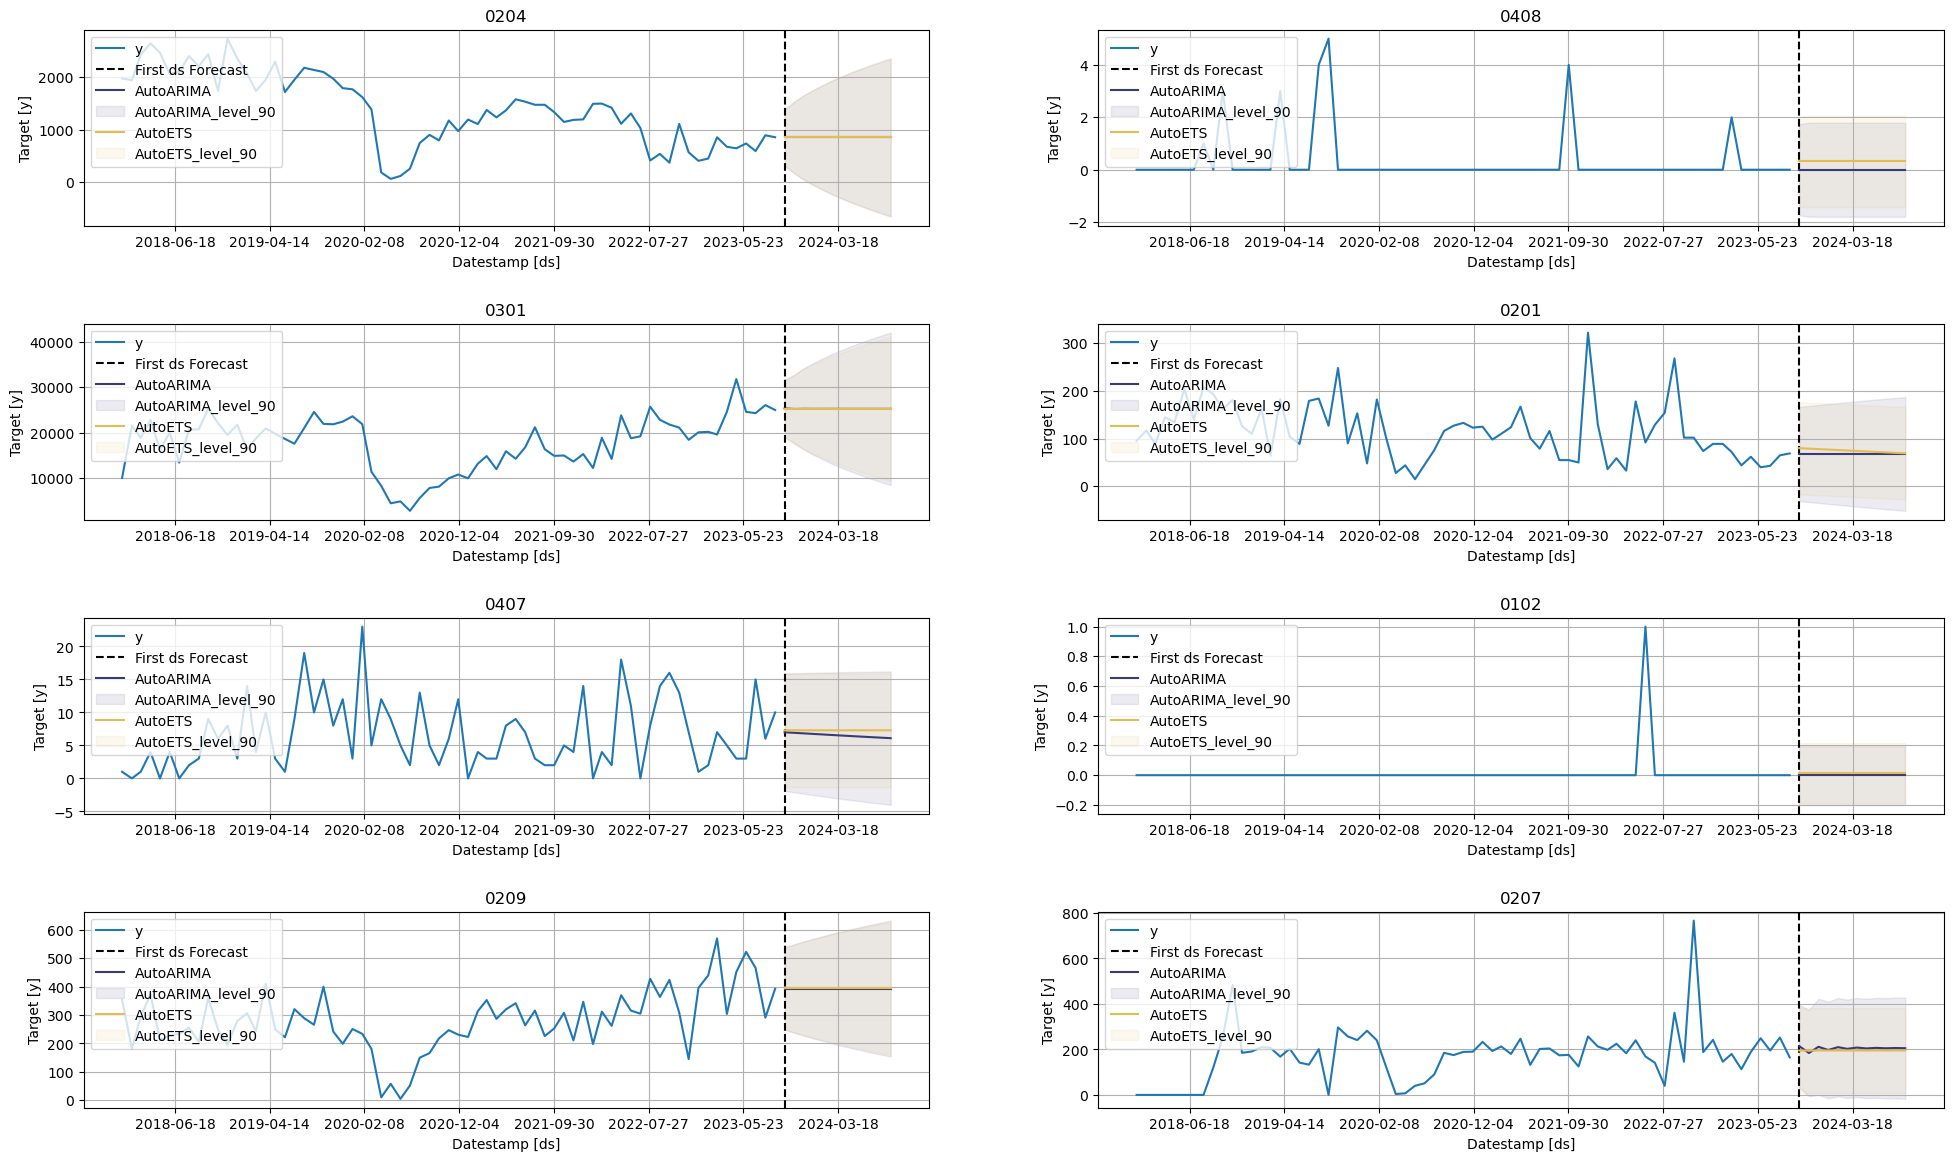

In [56]:
sf.plot(df=df,forecasts_df=forecast_df, unique_ids=autoets_ids, engine='matplotlib')

In [57]:
print(autoets_ids)

CategoricalIndex(['0102', '0201', '0202', '0203', '0204', '0205', '0207',
                  '0209', '0210', '0211', '0212', '0213', '0301', '0303',
                  '0304', '0305', '0309', '0401', '0403', '0405', '0406',
                  '0407', '0408', '0410', '0412', '0417', '0418', '0501',
                  '0506', '0701'],
                 categories=['0101', '0102', '0201', '0202', ..., '0501', '0506', '0701', '0702'], ordered=False, dtype='category', name='unique_id')


In [58]:
print(autoarima_ids)

CategoricalIndex(['0101', '0206', '0208', '0214', '0302', '0306', '0404',
                  '0409', '0413', '0415', '0702'],
                 categories=['0101', '0102', '0201', '0202', ..., '0501', '0506', '0701', '0702'], ordered=False, dtype='category', name='unique_id')


In [59]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df


In [60]:
prod_forecasts_df = get_best_model_forecast(forecast_df, evaluation_df)

prod_forecasts_df.to_csv(r"C:\Users\brvn\Documents\github\projects\HC\tcc_brvn\data\processed\forecasted-df.csv", float_format="%d")


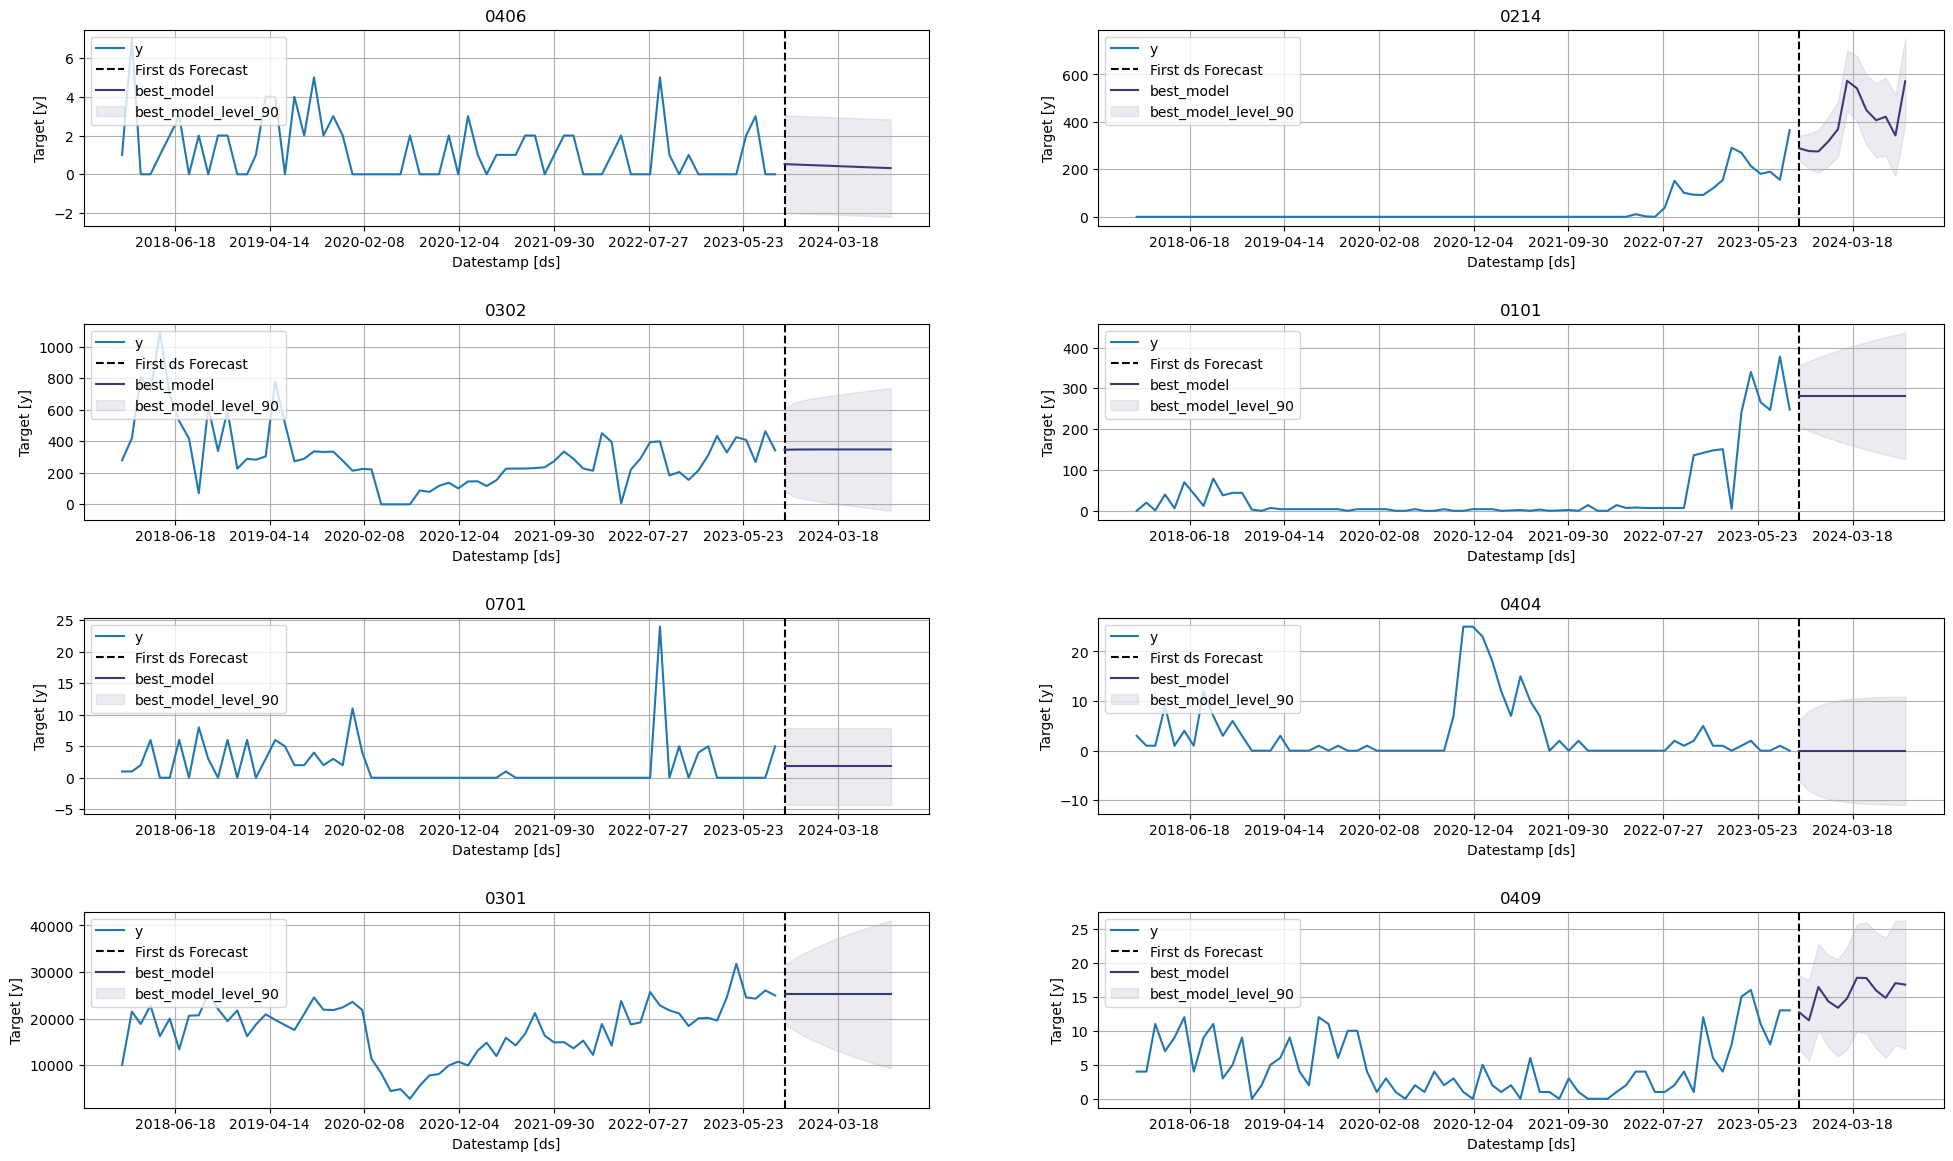

In [61]:
sf.plot(df, prod_forecasts_df, level=[90], engine='matplotlib')
